In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload


In [2]:
!pip install --upgrade numpyro
!pip install --upgrade funsor

Requirement already up-to-date: numpyro in /home/akotlar/miniconda3/lib/python3.8/site-packages (0.7.1)
Requirement already up-to-date: funsor in /home/akotlar/miniconda3/lib/python3.8/site-packages (0.4.1)


In [3]:
from mvl2 import genData2
from mvl2.numpyro import model, infer, run, set_platform, get_run_params_data
from torch import tensor
set_platform("cpu")

In [4]:
r_p = tensor([[1., 0], [0, 1.]])
r_g = tensor([[1., .5], [.5, 1.]])
v_p = tensor([.05, .05])
h2 = tensor([.9, .9])

popgen_params = genData2.get_popgen_param(h2=h2, v_p=v_p, r_p=r_p, r_g=r_g)

# popgen_params["cov_p"] = popgen_params["r_p"]
# popgen_params["cov_e"] = popgen_params["r_e"]
# popgen_params["cov_g"] = popgen_params["r_g"]
sim_params = {
    "pi": tensor([.1, .1, .05]),
    **popgen_params,
    "RR_mean": tensor([3., 2.]),
    "PV_shape": tensor(1.),
    "PV_mean": tensor(1e-4),
    "PD": tensor([.01, .01]),
    # "PD_both": tensor(.005),
    "n_cases": tensor([1.5e4, 1.5e4, 4e3]),
    "n_ctrls": tensor(5e4),
    "fudge_factor": .1
}
sim_params

{'pi': tensor([0.1000, 0.1000, 0.0500]),
 'r_p': tensor([[1., 0.],
         [0., 1.]]),
 'r_g': tensor([[1.0000, 0.5000],
         [0.5000, 1.0000]]),
 'r_e': tensor([[ 1.0000, -0.0450],
         [-0.0450,  1.0000]]),
 'v_p': tensor([0.0500, 0.0500]),
 'v_g': tensor([0.0450, 0.0450]),
 'v_e': tensor([0.0050, 0.0050]),
 'cov_p': tensor([[0.0500, 0.0000],
         [0.0000, 0.0500]]),
 'cov_g': tensor([[0.0450, 0.0225],
         [0.0225, 0.0450]]),
 'cov_e': tensor([[ 0.0050, -0.0002],
         [-0.0002,  0.0050]]),
 'RR_mean': tensor([3., 2.]),
 'PV_shape': tensor(1.),
 'PV_mean': tensor(1.0000e-04),
 'PD': tensor([0.0100, 0.0100]),
 'n_cases': tensor([15000., 15000.,  4000.]),
 'n_ctrls': tensor(50000.),
 'fudge_factor': 0.1}

In [5]:
sim_data = genData2.gen_counts(**sim_params)

/home/akotlar/tada/for-martin/mvl2/genData2.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PD_z_score = norm.icdf(tensor(1 - PD))
/home/akotlar/tada/for-martin/mvl2/genData2.py:117: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PD12V = mvn.cdf(tensor(disease_z_scores))


disease_z_scores tensor([-2.3263, -2.3263])
PD_with_both tensor([1.0000e-02, 1.0000e-02, 1.0000e-04], dtype=torch.float64)
mean_effects tensor([-0.4456, -0.2726])


In [6]:
sim_data["PVDs"].mean(0)

tensor([9.9899e-05, 1.2964e-04, 1.1539e-04, 1.5485e-04], dtype=torch.float64)

In [7]:
print(sim_data["PVDs"][sim_data["unaffected_genes"]].mean(0))
for i in range(len(sim_data["affected_genes"])):
    print(f"mean affects {i + 1}", sim_data["PVDs"][sim_data["affected_genes"][i]].mean(0))
    print(f"std affects {i + 1}", sim_data["PVDs"][sim_data["affected_genes"][i]].std(0))


tensor([0.0001, 0.0001, 0.0001, 0.0001], dtype=torch.float64)
mean affects 1 tensor([0.0001, 0.0001, 0.0002, 0.0002], dtype=torch.float64)
std affects 1 tensor([0.0001, 0.0001, 0.0002, 0.0002], dtype=torch.float64)
mean affects 2 tensor([9.8342e-05, 3.0411e-04, 2.0526e-04, 6.2194e-04], dtype=torch.float64)
std affects 2 tensor([0.0001, 0.0003, 0.0002, 0.0007], dtype=torch.float64)
mean affects 3 tensor([9.4972e-05, 2.9084e-04, 9.6970e-05, 2.9084e-04], dtype=torch.float64)
std affects 3 tensor([9.7847e-05, 3.0056e-04, 9.9907e-05, 3.0056e-04], dtype=torch.float64)


[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]


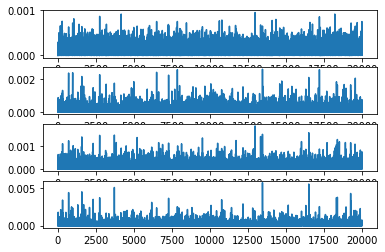

In [8]:
import matplotlib.pyplot as plt
fig, plts = plt.subplots(sim_data["PVDs"].shape[1])
print(plts)
for i in range(len(plts)):
    plts[i].plot(sim_data["PVDs"][:, i])

In [9]:
# With no prior on allele frequency
sim_params_point_pv = sim_params.copy()
sim_params_point_pv["PV_shape"] = None
sim_data_point_pv = genData2.gen_counts(**sim_params_point_pv)

/home/akotlar/tada/for-martin/mvl2/genData2.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PD_z_score = norm.icdf(tensor(1 - PD))
/home/akotlar/tada/for-martin/mvl2/genData2.py:128: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PV = tensor(PV_mean).expand([n_genes,])
/home/akotlar/tada/for-martin/mvl2/genData2.py:117: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PD12V = mvn.cdf(tensor(disease_z_scores))


disease_z_scores tensor([-2.3263, -2.3263])
PD_with_both tensor([1.0000e-02, 1.0000e-02, 1.0000e-04], dtype=torch.float64)
mean_effects tensor([-0.4456, -0.2726])


[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]


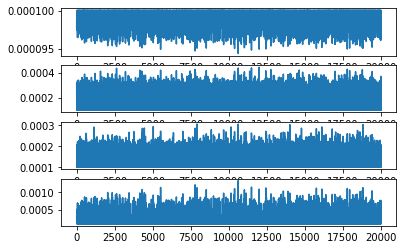

In [10]:
import matplotlib.pyplot as plt
fig, plts = plt.subplots(sim_data_point_pv["PVDs"].shape[1])
print(plts)
for i in range(len(plts)):
    plts[i].plot(sim_data_point_pv["PVDs"][:, i])

In [15]:
run_params = {
    "data": sim_data_point_pv["alt_counts"].numpy(),
    "n_cases": sim_params_point_pv["n_cases"].numpy(),
    "n_ctrls": sim_params_point_pv["n_ctrls"].numpy(),
    "max_tree_depth": 10,
    "num_warmup": 200,
    "num_samples": 1000,
    "num_chains": 1,
    "max_K": 12,
    "chain_method": 'sequential',
    "model_to_run": model,
    "jit_model_args": False
}

mcmc_prev, inferred_params_prev = run(sim_data=sim_params_point_pv, run_params=run_params)



warmup:   2%|▏         | 29/1200 [00:23<23:40,  1.21s/it, 1023 steps of size 1.45e-02. acc. prob=0.72]

In [12]:
prev_run_params, prev_sim_data = get_run_params_data('/home/akotlar/tada/for-martin/Mar-21-21-03-01-52_7c321948-94d0-4277-bcdb-24d93239be73')
prev_run_params['num_chains'] = 1
print(prev_run_params)

{'data': array([[6., 1., 1., 1.],
       [6., 2., 4., 1.],
       [4., 3., 2., 0.],
       ...,
       [8., 0., 1., 0.],
       [3., 9., 0., 1.],
       [7., 1., 1., 0.]]), 'n_cases': array([15000., 15000.,  4000.], dtype=float32), 'n_ctrls': array(50000., dtype=float32), 'max_tree_depth': 8, 'num_warmup': 200, 'num_samples': 1000, 'num_chains': 1, 'max_K': 12, 'chain_method': 'parallel', 'model_to_run': <function model at 0x7fb7f80a7700>, 'jit_model_args': False}


sample:  31%|███▏      | 376/1200 [03:45<08:13,  1.67it/s, 511 steps of size 7.91e-03. acc. prob=0.91]


KeyboardInterrupt: 

In [14]:
mcmc_prev, inferred_params_prev = run(sim_data=prev_sim_data, run_params={**prev_run_params, "max_tree_depth": 10})

[autoreload of mvl2.numpyro failed: Traceback (most recent call last):
  File "/home/akotlar/miniconda3/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/akotlar/miniconda3/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/home/akotlar/miniconda3/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/akotlar/miniconda3/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 779, in exec_module
  File "<frozen importlib._bootstrap_external>", line 916, in get_code
  File "<frozen importlib._bootstrap_external>", line 846, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/akotlar/

KeyboardInterrupt: 

In [29]:
print({**prev_run_params, "max_tree_depth": 10})

{'data': array([[6., 1., 1., 1.],
       [6., 2., 4., 1.],
       [4., 3., 2., 0.],
       ...,
       [8., 0., 1., 0.],
       [3., 9., 0., 1.],
       [7., 1., 1., 0.]]), 'n_cases': array([15000., 15000.,  4000.], dtype=float32), 'n_ctrls': array(50000., dtype=float32), 'max_tree_depth': 10, 'num_warmup': 200, 'num_samples': 1000, 'num_chains': 1, 'max_K': 12, 'chain_method': 'parallel', 'model_to_run': <function model at 0x7fdf90bd1b80>, 'jit_model_args': False, 'hmcecs_blocks': 10}


In [23]:
prev_run_params, prev_sim_data = get_run_params_data('/home/akotlar/tada/for-martin/Mar-21-21-03-01-52_7c321948-94d0-4277-bcdb-24d93239be73')
prev_run_params['num_chains'] = 1
prev_run_params['hmcecs_blocks'] = 10
print(prev_run_params)
mcmc_prev, inferred_params_prev = run(sim_data=prev_sim_data, run_params=prev_run_params)

{'data': array([[6., 1., 1., 1.],
       [6., 2., 4., 1.],
       [4., 3., 2., 0.],
       ...,
       [8., 0., 1., 0.],
       [3., 9., 0., 1.],
       [7., 1., 1., 0.]]), 'n_cases': array([15000., 15000.,  4000.], dtype=float32), 'n_ctrls': array(50000., dtype=float32), 'max_tree_depth': 8, 'num_warmup': 200, 'num_samples': 1000, 'num_chains': 1, 'max_K': 12, 'chain_method': 'parallel', 'model_to_run': <function model at 0x7fdf90bd1b80>, 'jit_model_args': False, 'hmcecs_blocks': 10}


ValueError: The algorithm only works with HMC and and does not support NUTS.

In [6]:
prev_run_params, prev_sim_data = get_run_params_data('/home/akotlar/tada/for-martin/Mar-21-21-03-01-52_7c321948-94d0-4277-bcdb-24d93239be73')
print(prev_run_params)
mcmc_prev, inferred_params_prev = run(sim_data=prev_sim_data, run_params=prev_run_params)

{'data': array([[6., 1., 1., 1.],
       [6., 2., 4., 1.],
       [4., 3., 2., 0.],
       ...,
       [8., 0., 1., 0.],
       [3., 9., 0., 1.],
       [7., 1., 1., 0.]]), 'n_cases': array([15000., 15000.,  4000.], dtype=float32), 'n_ctrls': array(50000., dtype=float32), 'max_tree_depth': 8, 'num_warmup': 200, 'num_samples': 1000, 'num_chains': 4, 'max_K': 12, 'chain_method': 'parallel', 'model_to_run': <function model at 0x7fcbc5df3430>, 'jit_model_args': False}
Compiling.. :   0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Compiling.. :   0%|          | 0/1200 [00:00<?, ?it/s]


  0%|          | 0/1200 [00:00<?, ?it/s]


Running chain 1:   0%|          | 0/1200 [00:06<?, ?it/s]

Running chain 2:   0%|          | 0/1200 [00:06<?, ?it/s]


Running chain 1:   5%|▌         | 60/1200 [00:25<06:00,  3.16it/s]


Running chain 0:   5%|▌         | 60/1200 [00:28<06:46,  2.80it/s]

Running chain 2:   5%|▌         | 60/1200 [00:28<06:49,  2.78it/s]


Running 

In [7]:
prev_run_params, prev_sim_data = get_run_params_data('/home/akotlar/tada/for-martin/Mar-21-21-03-01-52_7c321948-94d0-4277-bcdb-24d93239be73')
prev_run_params["max_tree_depth"] = 10
mcmc_prev, inferred_params_prev = run(sim_data=prev_sim_data, run_params=prev_run_params)

Compiling.. :   0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Compiling.. :   0%|          | 0/1200 [00:00<?, ?it/s]


  0%|          | 0/1200 [00:00<?, ?it/s]


Compiling.. :   0%|          | 0/1200 [00:00<?, ?it/s]

Running chain 0:   0%|          | 0/1200 [00:06<?, ?it/s]


Running chain 3:   0%|          | 0/1200 [00:06<?, ?it/s]

Running chain 1:   5%|▌         | 60/1200 [01:18<22:38,  1.19s/it]


Running chain 0:   5%|▌         | 60/1200 [01:34<27:58,  1.47s/it]

Running chain 2:  10%|█         | 120/1200 [02:14<18:33,  1.03s/it]

Running chain 1:  10%|█         | 120/1200 [02:34<21:54,  1.22s/it]

Running chain 2:  20%|██        | 240/1200 [02:35<09:27,  1.69it/s]

Running chain 2:  25%|██▌       | 300/1200 [02:42<06:43,  2.23it/s]


Running chain 1:  15%|█▌        | 180/1200 [02:48<15:37,  1.09it/s]

Running chain 0:  10%|█         | 120/1200 [02:53<25:35,  1.42s/it]

Running chain 1:  20%|██        | 240/1200 [02:55<10:54,  1.47it/s]


Runni

In [8]:
prev_run_params, prev_sim_data = get_run_params_data('/home/akotlar/tada/for-martin/Mar-21-21-03-01-52_7c321948-94d0-4277-bcdb-24d93239be73')
prev_run_params["num_samples"] = 2000
mcmc_prev, inferred_params_prev = run(sim_data=prev_sim_data, run_params=prev_run_params)

Compiling.. :   0%|          | 0/2200 [00:00<?, ?it/s]

  0%|          | 0/2200 [00:00<?, ?it/s]

Compiling.. :   0%|          | 0/2200 [00:00<?, ?it/s]


  0%|          | 0/2200 [00:00<?, ?it/s]


Running chain 0:   0%|          | 0/2200 [00:06<?, ?it/s]

Running chain 2:   0%|          | 0/2200 [00:06<?, ?it/s]


Running chain 1:   5%|▌         | 110/2200 [00:45<12:17,  2.83it/s]


Running chain 3:   5%|▌         | 110/2200 [00:46<12:43,  2.74it/s]

Running chain 0:   5%|▌         | 110/2200 [00:49<13:27,  2.59it/s]


Running chain 3:  10%|█         | 220/2200 [01:04<10:00,  3.30it/s]

Running chain 1:  10%|█         | 220/2200 [01:05<09:57,  3.31it/s]


Running chain 0:  10%|█         | 220/2200 [01:17<11:30,  2.87it/s]

Running chain 1:  15%|█▌        | 330/2200 [01:25<08:16,  3.77it/s]

Running chain 2:  20%|██        | 440/2200 [01:29<06:04,  4.83it/s]


Running chain 1:  20%|██        | 440/2200 [01:41<06:44,  4.35it/s]


Running chain 3:  25%|██▌       | 550/2200 [01:41<04:54, 

In [9]:
prev_run_params, prev_sim_data = get_run_params_data('/home/akotlar/tada/for-martin/Mar-21-21-03-01-52_7c321948-94d0-4277-bcdb-24d93239be73')
prev_run_params["max_tree_depth"] = 10

prev_run_params["num_samples"] = 2000
mcmc_prev, inferred_params_prev = run(sim_data=prev_sim_data, run_params=prev_run_params)

Compiling.. :   0%|          | 0/2200 [00:00<?, ?it/s]

  0%|          | 0/2200 [00:00<?, ?it/s]

Compiling.. :   0%|          | 0/2200 [00:00<?, ?it/s]


  0%|          | 0/2200 [00:00<?, ?it/s]


Compiling.. :   0%|          | 0/2200 [00:00<?, ?it/s]


Running chain 0:   0%|          | 0/2200 [00:06<?, ?it/s]

Running chain 2:   0%|          | 0/2200 [00:06<?, ?it/s]


Running chain 3:   5%|▌         | 110/2200 [02:14<40:19,  1.16s/it]

Running chain 1:  10%|█         | 220/2200 [02:41<30:51,  1.07it/s]

Running chain 0:  10%|█         | 220/2200 [02:57<31:49,  1.04it/s]

Running chain 1:  25%|██▌       | 550/2200 [03:14<10:35,  2.60it/s]

Running chain 1:  35%|███▌      | 770/2200 [03:36<05:41,  4.19it/s]

Running chain 2:  25%|██▌       | 550/2200 [03:36<11:32,  2.38it/s]


Running chain 0:  25%|██▌       | 550/2200 [03:47<11:53,  2.31it/s]

Running chain 1:  50%|█████     | 1100/2200 [04:07<02:38,  6.93it/s]

Running chain 2:  35%|███▌      | 770/2200 [04:16<07:08,  3.34it/s]


Ru

In [11]:
mcmc, inferred_params = run(sim_data=sim_data_point_pv, run_params=run_params)

sample: 100%|██████████| 1200/1200 [02:36<00:00,  7.68it/s, 22 steps of size 8.40e-02. acc. prob=0.83]

                 mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta[0]      0.70      0.03      0.70      0.66      0.74    317.64      1.00
    beta[1]      0.47      0.07      0.47      0.37      0.59    282.06      1.00
    beta[2]      0.52      0.11      0.52      0.34      0.68    229.35      1.00
    beta[3]      1.00      0.00      1.00      1.00      1.00    564.82      1.00
    beta[4]      0.93      0.17      1.00      0.74      1.00    690.77      1.00
    beta[5]      0.92      0.18      1.00      0.72      1.00    757.10      1.00
    beta[6]      0.93      0.16      1.00      0.78      1.00    468.47      1.00
    beta[7]      0.94      0.16      1.00      0.77      1.00    744.80      1.00
    beta[8]      0.94      0.16      1.00      0.82      1.00    715.60      1.00
    beta[9]      0.93      0.17      1.00      0.76      1.00    859.76     

In [14]:
import numpyro
numpyro.enable_x64(use_x64=True)
mcmc, inferred_params = run(sim_data=sim_data_point_pv, run_params=run_params)

sample: 100%|██████████| 1200/1200 [08:39<00:00,  2.31it/s, 127 steps of size 5.41e-02. acc. prob=0.87]

                 mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta[0]      0.70      0.03      0.70      0.66      0.74    494.25      1.00
    beta[1]      0.47      0.07      0.47      0.37      0.59    381.49      1.00
    beta[2]      0.52      0.11      0.53      0.34      0.69    386.61      1.00
    beta[3]      1.00      0.00      1.00      1.00      1.00   1017.76      1.00
    beta[4]      0.97      0.12      1.00      0.96      1.00    886.50      1.00
    beta[5]      0.98      0.09      1.00      0.98      1.00   1074.77      1.00
    beta[6]      0.97      0.12      1.00      0.97      1.00   1003.88      1.00
    beta[7]      0.98      0.10      1.00      0.97      1.00    982.63      1.00
    beta[8]      0.97      0.13      1.00      0.97      1.00    844.16      1.00
    beta[9]      0.98      0.10      1.00      0.99      1.00   1056.57    

In [16]:
run_params2 = run_params.copy()
run_params2["num_chains"] = 4
mcmc2, inferred_params2 = run(sim_data=sim_data_point_pv, run_params=run_params2)

Compiling.. :   0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Compiling.. :   0%|          | 0/1200 [00:00<?, ?it/s]


  0%|          | 0/1200 [00:00<?, ?it/s]


Compiling.. :   0%|          | 0/1200 [00:00<?, ?it/s]


Running chain 3:   0%|          | 0/1200 [00:06<?, ?it/s]

Running chain 0:   5%|▌         | 60/1200 [01:01<17:24,  1.09it/s]


Running chain 3:   5%|▌         | 60/1200 [01:03<17:49,  1.07it/s]

Running chain 1:  10%|█         | 120/1200 [01:54<15:24,  1.17it/s]


Running chain 0:  10%|█         | 120/1200 [02:04<17:10,  1.05it/s]

Running chain 1:  15%|█▌        | 180/1200 [02:34<13:34,  1.25it/s]


Running chain 1:  20%|██        | 240/1200 [03:09<11:42,  1.37it/s]

Running chain 2:  15%|█▌        | 180/1200 [03:17<17:38,  1.04s/it]


Running chain 1:  25%|██▌       | 300/1200 [03:43<10:16,  1.46it/s]


Running chain 1:  30%|███       | 360/1200 [04:18<09:08,  1.53it/s]

Running chain 2:  20%|██        | 240/1200 [04:26<17:10,  1.07

In [12]:
mcmc, inferred_params = run(sim_data=sim_data_point_pv, run_params=run_params)

sample: 100%|██████████| 1200/1200 [02:17<00:00,  8.74it/s, 123 steps of size 7.04e-02. acc. prob=0.85]

                 mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta[0]      0.71      0.03      0.71      0.66      0.75    244.79      1.00
    beta[1]      0.26      0.07      0.25      0.16      0.37    118.96      1.00
    beta[2]      0.66      0.07      0.67      0.54      0.78    227.05      1.00
    beta[3]      1.00      0.00      1.00      1.00      1.00    729.34      1.00
    beta[4]      0.93      0.18      1.00      0.74      1.00    557.16      1.00
    beta[5]      0.93      0.17      1.00      0.75      1.00    740.60      1.00
    beta[6]      0.93      0.17      1.00      0.79      1.00    513.63      1.00
    beta[7]      0.94      0.16      1.00      0.80      1.00    662.22      1.00
    beta[8]      0.93      0.17      1.00      0.73      1.00    687.02      1.00
    beta[9]      0.93      0.18      1.00      0.71      1.00    627.84    

In [11]:
run_params2 = run_params.copy()
run_params2["num_chains"] = 4
mcmc2, inferred_params2 = run(sim_data=sim_data_point_pv, run_params=run_params2)

Compiling.. :   0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Compiling.. :   0%|          | 0/1200 [00:00<?, ?it/s]


  0%|          | 0/1200 [00:00<?, ?it/s]


Running chain 1:   0%|          | 0/1200 [00:06<?, ?it/s]

Running chain 0:   0%|          | 0/1200 [00:06<?, ?it/s]


Running chain 3:   0%|          | 0/1200 [00:06<?, ?it/s]


Running chain 3:   5%|▌         | 60/1200 [00:27<06:37,  2.87it/s]

Running chain 1:   5%|▌         | 60/1200 [00:29<06:59,  2.71it/s]


Running chain 1:  10%|█         | 120/1200 [00:50<06:35,  2.73it/s]

Running chain 2:  10%|█         | 120/1200 [00:52<06:36,  2.73it/s]


Running chain 1:  15%|█▌        | 180/1200 [01:02<05:22,  3.16it/s]


Running chain 3:  20%|██        | 240/1200 [01:03<03:39,  4.38it/s]


Running chain 1:  20%|██        | 240/1200 [01:09<04:05,  3.90it/s]

Running chain 0:  20%|██        | 240/1200 [01:12<04:18,  3.72it/s]


Running chain 1:  25%|██▌       | 300/1200 [01:15<03:08,  4.77it/s]


In [15]:
run_params3 = run_params.copy()
run_params3["num_chains"] = 4
run_params3["max_tree_depth"] = 10
mcmc3, inferred_params3 = run(sim_data=sim_data_point_pv, run_params=run_params3)

Compiling.. :   0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Compiling.. :   0%|          | 0/1200 [00:00<?, ?it/s]


  0%|          | 0/1200 [00:00<?, ?it/s]


Running chain 0:   0%|          | 0/1200 [00:06<?, ?it/s]


Running chain 1:   0%|          | 0/1200 [00:06<?, ?it/s]

Running chain 1:   5%|▌         | 60/1200 [01:25<24:47,  1.31s/it]


Running chain 3:   5%|▌         | 60/1200 [01:28<25:42,  1.35s/it]

Running chain 2:   5%|▌         | 60/1200 [01:28<25:47,  1.36s/it]

Running chain 1:  10%|█         | 120/1200 [02:39<23:09,  1.29s/it]

Running chain 2:  15%|█▌        | 180/1200 [02:42<15:57,  1.06it/s]


Running chain 0:  15%|█▌        | 180/1200 [02:51<16:07,  1.05it/s]

Running chain 1:  20%|██        | 240/1200 [03:00<11:30,  1.39it/s]


Running chain 0:  20%|██        | 240/1200 [03:05<11:42,  1.37it/s]

Running chain 0:  25%|██▌       | 300/1200 [03:17<08:35,  1.75it/s]


Running chain 1:  30%|███       | 360/1200 [03:20<06:05,  2.3

In [16]:
mcmc4, inferred_params4 = run(sim_data=sim_data_point_pv, run_params=run_params4)

sample: 100%|██████████| 1200/1200 [04:18<00:00,  4.64it/s, 255 steps of size 5.77e-02. acc. prob=0.86]
                 mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta[0]      0.25      0.26      0.12      0.05      0.71      2.02     11.37
    beta[1]      0.49      0.31      0.58      0.08      0.85      2.03      8.45
    beta[2]      0.50      0.21      0.42      0.26      0.85      2.22      3.10
    beta[3]      1.00      0.00      1.00      1.00      1.00   3176.38      1.00
    beta[4]      0.94      0.16      1.00      0.80      1.00   2891.18      1.00
    beta[5]      0.93      0.17      1.00      0.74      1.00   3002.97      1.00
    beta[6]      0.93      0.17      1.00      0.78      1.00   2332.85      1.00
    beta[7]      0.94      0.17      1.00      0.80      1.00   2795.79      1.00
    beta[8]      0.93      0.17      1.00      0.76      1.00   2777.71      1.00
    beta[9]      0.92      0.18      1.00      0.73      1.00   2972.17     

In [14]:
from joblib import Parallel, delayed
import multiprocessing
from joblib.externals.loky import set_loky_pickler
set_loky_pickler("dill")

inferred_params_sequential = []
mcmc_res_sequential = []

def run_chains(sim_data, run_params):
    mcmc_res, inferred_params_res = run(sim_data=sim_data_point_pv, run_params=run_params)
    return mcmc_res, inferred_params_res

for i in range(4):
    a, b = run_chains(sim_data_point_pv, run_params)
    mcmc_res_sequential.append(a)
    inferred_params_sequential.append(b)
#cannot pickle 'weakref' object
#results = Parallel(n_jobs=4)(delayed(run_chains)(sim_data_point_pv, run_params) for _ in range(4))

0.07292452 0.03072397 0.03141278 0.11797734 0.11253525 0.03159084
 0.03159116 0.03137563 0.03085728 0.03155382 0.0315883  0.0315912 ]
  0%|          | 0/1200 [00:00<?, ?it/s]
                 mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta[0]      0.18      0.07      0.17      0.07      0.27    262.78      1.00
    beta[1]      0.09      0.02      0.09      0.05      0.12    665.03      1.00
    beta[2]      0.19      0.04      0.18      0.12      0.24    286.82      1.00
    beta[3]      0.97      0.16      1.00      0.99      1.00     35.06      1.03
    beta[4]      0.95      0.14      1.00      0.88      1.00    605.95      1.00
    beta[5]      0.94      0.15      1.00      0.78      1.00    876.04      1.00
    beta[6]      0.93      0.19      1.00      0.76      1.00    636.94      1.00
    beta[7]      0.94      0.15      1.00      0.83      1.00    795.85      1.00
    beta[8]      0.94      0.17      1.00      0.78      1.00    594.12      1.00
    b

In [15]:
run_params_parallel = run_params.copy()
run_params_parallel["num_chains"] = 4
mcmc_parallel, inferred_parallel = run(sim_data=sim_data_point_pv, run_params=run_params_parallel)

Compiling.. :   0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Compiling.. :   0%|          | 0/1200 [00:00<?, ?it/s]


  0%|          | 0/1200 [00:00<?, ?it/s]


Running chain 1:   0%|          | 0/1200 [00:06<?, ?it/s]


Running chain 3:   0%|          | 0/1200 [00:06<?, ?it/s]

Running chain 2:   0%|          | 0/1200 [00:06<?, ?it/s]

Running chain 0:   5%|▌         | 60/1200 [00:28<06:50,  2.78it/s]


Running chain 0:  10%|█         | 120/1200 [00:48<06:20,  2.84it/s]

Running chain 2:  10%|█         | 120/1200 [00:50<06:18,  2.85it/s]


Running chain 0:  15%|█▌        | 180/1200 [01:00<05:10,  3.29it/s]

Running chain 0:  20%|██        | 240/1200 [01:08<04:03,  3.95it/s]

Running chain 2:  20%|██        | 240/1200 [01:14<04:22,  3.66it/s]


Running chain 0:  30%|███       | 360/1200 [01:23<02:37,  5.32it/s]

Running chain 0:  40%|████      | 480/1200 [01:38<01:52,  6.41it/s]


Running chain 3:  20%|██        | 240/1200 [01:40<06:09,  2.60it/s]



In [20]:
!pip install joblib
from joblib import Parallel, delayed
import multiprocessing

inputs = range(10) RRRRRRRRRRRRRRRRRRRRRRRRRRRRRR
def processInput(i):
    return i * i, i*2

num_cores = multiprocessing.cpu_count()

i = Parallel(n_jobs=num_cores)(delayed(processInput)(i) for i in inputs)
i = Parallel(n_jobs=num_cores)(delayed(processInput)(i) for i in inputs)
print(i)

[(0, 0), (1, 2), (4, 4), (9, 6), (16, 8), (25, 10), (36, 12), (49, 14), (64, 16), (81, 18)]


In [1]:
# Experiment with pyro instead of numpyro

import pyro
from pyro.distributions import Multinomial as MN
import pyro.distributions as pdist
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from pyro.optim import Adam

import torch
import torch.nn.functional as F
from torch.distributions import constraints

import pyro
from pyro.distributions import *
from pyro.infer import Predictive, SVI, TraceEnum_ELBO
from pyro.optim import Adam
from pyro.infer import config_enumerate
assert pyro.__version__.startswith('1')
pyro.enable_validation(True)       # can help with debugging
pyro.set_rng_seed(0)

nHypotheses = 6
kConditions = 4
N = len(liabData55cov["altCounts"])

nCases = liabParams55cov["nCases"]
nCtrls = liabParams55cov["nCtrls"]
samplePDs = nCases / (nCases.sum() + nCtrls)
pdsAll = tensor([1 - samplePDs.sum(), *samplePDs])

pdsAllShaped = pdsAll.expand(nHypotheses, kConditions)
T = nHypotheses

def mix_weights(beta):
    beta1m_cumprod = (1 - beta).cumprod(-1)
    return F.pad(beta, (0, 1), value=1) * F.pad(beta1m_cumprod, (1, 0), value=1)


alpha = 0.01
def model(data):
    with pyro.plate("beta_plate", nHypotheses-1):
        beta = pyro.sample("beta", Beta(1.0, alpha))

    with pyro.plate("probs_plate", nHypotheses):
        conc = pyro.sample('conc', Gamma(1.0/torch.ones([nHypotheses, kConditions]), 1.0).to_event(1))
        # Alex: this could maybe be fixed parameters, shared across all observations with different patterns
        # in which case it's not needed
        # or could we patterned independently per cluster as raymond had suggested
        probs = pyro.sample("probs", Dirichlet(conc*pdsAll))

    with pyro.plate("data", N):
        z = pyro.sample("z", Categorical(mix_weights(beta)), infer={"enumerate": "parallel"} )
        return pyro.sample("obs", MN(probs=probs[z], validate_args=False), obs=data)
    
# # Use autonormal guide start
# def guide(data):
#     # alphas = pyro.sample('alphas', Gamma(1.0/torch.ones([nHypotheses, kConditions]), 1))
#     # print("alphas", alphas)
#     beta_center = pyro.param('beta_center', lambda: Uniform(0, 2).sample([T-1]), constraint=constraints.positive)
#     kappa = pyro.param('kappa', lambda: Uniform(0, 2).sample([T-1]), constraint=constraints.positive)
#     # tau = pyro.param('tau', lambda: MultivariateNormal(torch.zeros(2), 3 * torch.eye(2)).sample([T]))
#     phi = pyro.param('phi', lambda: Dirichlet(1/nHypotheses * torch.ones(nHypotheses)).sample([N]), constraint=constraints.simplex)
#     # print("alphas", alphas)
#     with pyro.plate("beta_plate", nHypotheses-1):
#         q_beta = pyro.sample("beta", Beta(beta_center, kappa))

#     with pyro.plate("probs_plate", nHypotheses):
#         conc = pyro.sample('conc', Gamma(1.0/torch.ones([nHypotheses, kConditions]), 1).to_event(1))
#         # alphas = pyro.sample("alphas", Uniform(torch.ones(pdsAllShaped.shape), 25000))
#         # print("alphas", alphas)
#         probs = pyro.sample("probs", Dirichlet(conc*pdsAll))
#         # scaledProbs = pyro.deterministic("probs", probs * pdsAllShaped)

#     with pyro.plate("data", N):
#         z = pyro.sample("z", Categorical(phi))
# print("past")

# import pyro
# from pyro.distributions import Multinomial as MN
# import pyro.distributions as pdist
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
# from tqdm import tqdm

# import torch
# import torch.nn.functional as F
# from torch.distributions import constraints

# import pyro
# from pyro.distributions import *
# from pyro.infer import Predictive, SVI, Trace_ELBO
# from pyro.optim import Adam

# assert pyro.__version__.startswith('1')
# pyro.enable_validation(True)       # can help with debugging
# pyro.set_rng_seed(0)

# nHypotheses = 6
# kConditions = 4
# N = len(liabData55cov["altCounts"])

# nCases = liabParams55cov["nCases"]
# nCtrls = liabParams55cov["nCtrls"]
# samplePDs = nCases / (nCases.sum() + nCtrls)
# pdsAll = tensor([1 - samplePDs.sum(), *samplePDs])
# print("pdsAll", pdsAll)
# # pdsAllPop = tensor([1 - pDs.sum(), *pDs])
# # print("pdsall", pdsAllPop)
# # pdsAll = pdsAllPop
# pdsAllShaped = pdsAll.expand(nHypotheses, kConditions)
# print(nHypotheses)
# T = nHypotheses
# def mix_weights(beta):
#     beta1m_cumprod = (1 - beta).cumprod(-1)
#     return F.pad(beta, (0, 1), value=1) * F.pad(beta1m_cumprod, (1, 0), value=1)
# print("pdsAllShaped", pdsAllShaped)

# alpha = tensor(.01)
# # tfpdsAllShaped = tf.convert_to_tensor(pdsAllShaped)
# # total_count = liabData55cov["altCounts"].sum(1)
# # print(total_count.shape, total_count)
# def model2(data):
#     alphas = pyro.param('alphas', Uniform(torch.ones([nHypotheses, kConditions]), tensor(25000)))
#     probs = pyro.sample("probs", Dirichlet(alphas).to_event(1))
    
#     with pyro.plate("beta_plate", nHypotheses-1):
#         beta = pyro.sample("beta", Beta(1, alpha))

#     with pyro.plate("data", N):
#         # print('beta', beta)
#         z = pyro.sample("z", Categorical(mix_weights(beta)))
#         # print("probs in data plate", "z", z, "probs[z]", probs[z])
#         return pyro.sample("obs", MN(probs=probs[z], validate_args=False), obs=data)
    
# def guide2(data):
#     # alphas = pyro.param("alphas", Uniform(torch.ones(kConditions), 25000).sample([T]), constraint=constraints.positive)
#     beta_center = pyro.param('beta_center', lambda: Uniform(0, 2).sample([T-1]), constraint=constraints.positive)
#     kappa = pyro.param('kappa', lambda: Uniform(0, 2).sample([T-1]), constraint=constraints.positive)
#     # tau = pyro.param('tau', lambda: MultivariateNormal(torch.zeros(2), 3 * torch.eye(2)).sample([T]))
#     phi = pyro.param('phi', lambda: Dirichlet(1/nHypotheses * torch.ones(nHypotheses)).sample([N]), constraint=constraints.simplex)
#     # print("alphas", alphas)
#     alphas = pyro.param('alphas', Uniform(torch.ones([nHypotheses, kConditions]), tensor(25000)))
#     probs = pyro.sample("probs", Dirichlet(alphas).to_event(1))

#     with pyro.plate("beta_plate", nHypotheses-1):
#         q_beta = pyro.sample("beta", Beta(beta_center, kappa))

#     with pyro.plate("data", N):
#         z = pyro.sample("z", Categorical(phi))



NameError: name 'liabData55cov' is not defined

In [ ]:
from pyro.infer.autoguide import AutoDelta, AutoNormal
optim = Adam({"lr": 0.05})
guide = AutoNormal(model)

svi = SVI(model, guide, optim, loss=TraceEnum_ELBO())
losses = []
def train(num_iterations):
    pyro.clear_param_store()
    for j in tqdm(range(num_iterations)):
        loss = svi.step(liabData55cov["altCounts"].float())
        losses.append(loss)

def truncate(alpha, weights):
    threshold = alpha**-1 / 100.
    # true_centers = centers[weights > threshold]
    true_weights = weights[weights > threshold] / torch.sum(weights[weights > threshold])
    return true_weights

# alpha = 0.1
train(1000)

# We make a point-estimate of our model parameters using the posterior means of tau and phi for the centers and weights
# Bayes_Centers_01, Bayes_Weights_01 = truncate(alpha, pyro.param("tau").detach(), torch.mean(pyro.param("phi").detach(), dim=0))
